In [48]:
import keras
from keras.models import Sequential
from keras.layers import (Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten)
from keras.utils import plot_model
import numpy as np
from skimage.transform import resize
import plotly.express as px
import plotly.graph_objs as go

from phdr.data.hoda_dataset_reader import read_hoda_cdb, read_hoda_dataset

In [49]:
np.random.seed(42)

In [50]:
dataset_path = "../data/raw/hoda/"

print('Reading Train 60000.cdb ...')
x_train_org, y_train_org = read_hoda_cdb(dataset_path + 'train_60k.cdb')

print('Reading Test 20000.cdb ...')
x_test_org, y_test_org = read_hoda_cdb(dataset_path + 'test_20k.cdb')

# print('Reading RemainingSamples.cdb ...')
# remaining_images, remaining_labels = read_hoda_cdb(dataset_path + 'remaining_samples.cdb')

Reading Train 60000.cdb ...
Reading Test 20000.cdb ...


In [17]:
print(len(y_train_org))
print(len(y_test_org))

60000
20000


In [51]:
data_ratio = 0.15
x_train = x_train_org[:int(len(x_train_org) * data_ratio)]
y_train = y_train_org[:int(len(y_train_org) * data_ratio)]
x_test = x_test_org[:int(len(x_test_org) * data_ratio)]
y_test = y_test_org[:int(len(y_test_org) * data_ratio)]

x_valid = x_train[int(len(x_train) * 0.8):]
y_valid = y_train[int(len(y_train) * 0.8):]

x_train = x_train[:int(len(x_train) * 0.8)]
y_train = y_train[:int(len(y_train) * 0.8)]

print(len(x_train))
print(len(x_valid))
print(len(x_test))

7200
1800
3000


In [52]:
# reshape images to 25x25
x_train = [resize(image, (25, 25)) for image in x_train]
x_valid = [resize(image, (25, 25)) for image in x_valid]
x_test = [resize(image, (25, 25)) for image in x_test]
x_test[-1].shape

(25, 25)

In [53]:
print(x_test[0].shape)
x_test[-1].shape

(25, 25)


(25, 25)

In [54]:
x_train = np.array(x_train).astype('float32')
y_train = keras.utils.to_categorical(y_train, 10)
x_valid = np.array(x_valid).astype('float32')
y_valid = keras.utils.to_categorical(y_valid, 10)
x_test = np.array(x_test).astype('float32')
y_test = keras.utils.to_categorical(y_test, 10)
x_train /= 255
x_test /= 255
print(x_test.shape)
print(y_test.shape)

(3000, 25, 25)
(3000, 10)


In [66]:
model = Sequential()
model.add(Conv2D(25, (3, 3), activation='relu', input_shape=(25, 25, 1)))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 23, 23, 25)        250       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 11, 11, 25)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 9, 9, 64)          14464     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 2, 2, 64)          36928     
                                                                 
 flatten_6 (Flatten)         (None, 256)              

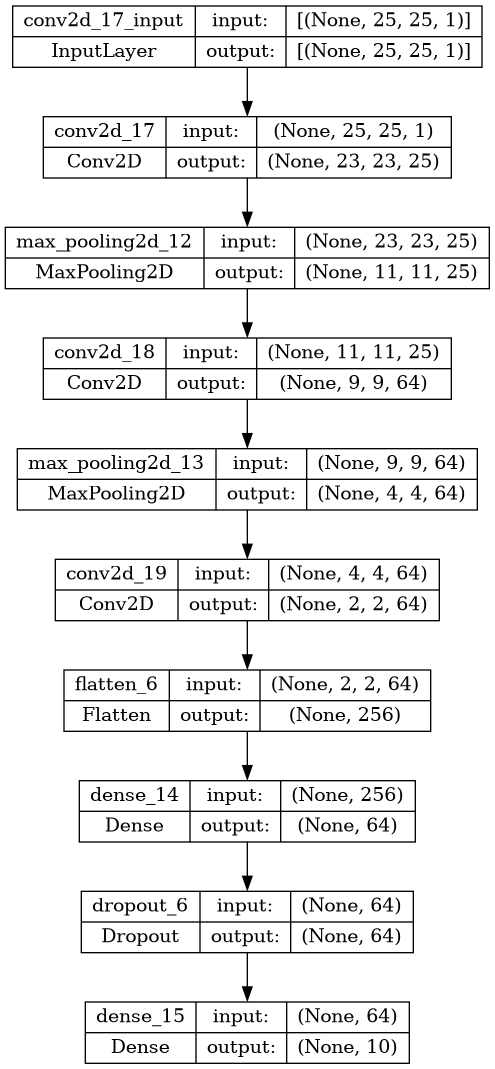

In [67]:
plot_model(model, show_shapes=True)

In [68]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [76]:
history = model.fit(
    x_train,
    y_train,
    epochs=200,
    batch_size=128,
    validation_data=(x_valid, y_valid),
    verbose=True
)

Epoch 1/200
57/57 [==============================] - 1s 11ms/step - loss: 0.1422 - accuracy: 0.9485 - val_loss: 331.4106 - val_accuracy: 0.4600
Epoch 2/200
57/57 [==============================] - 1s 11ms/step - loss: 0.1307 - accuracy: 0.9533 - val_loss: 347.1815 - val_accuracy: 0.4517
Epoch 3/200
57/57 [==============================] - 1s 12ms/step - loss: 0.1286 - accuracy: 0.9543 - val_loss: 334.9058 - val_accuracy: 0.4572
Epoch 4/200
57/57 [==============================] - 1s 10ms/step - loss: 0.1261 - accuracy: 0.9551 - val_loss: 382.5135 - val_accuracy: 0.4356
Epoch 5/200
57/57 [==============================] - 1s 10ms/step - loss: 0.1287 - accuracy: 0.9556 - val_loss: 315.2821 - val_accuracy: 0.4772
Epoch 6/200
57/57 [==============================] - 1s 10ms/step - loss: 0.1236 - accuracy: 0.9568 - val_loss: 354.6005 - val_accuracy: 0.4533
Epoch 7/200
57/57 [==============================] - 1s 10ms/step - loss: 0.1214 - accuracy: 0.9571 - val_loss: 379.1333 - val_accuracy:

In [77]:
# Plot training & validation accuracy values
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=history.history['accuracy'],
    mode='lines+markers',
    name='Train'
))
fig.add_trace(go.Scatter(
    y=history.history['val_accuracy'],
    mode='lines+markers',
    name='Validation'
))
fig.update_layout(
    title='Model accuracy',
    xaxis_title='Epoch',
    yaxis_title='Accuracy'
)
fig.show()

In [78]:
# Plot training & validation loss values
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=history.history['loss'],
    mode='lines+markers',
    name='Train'
))
fig.add_trace(go.Scatter(
    y=history.history['val_loss'],
    mode='lines+markers',
    name='Validation'
))
fig.update_layout(
    title='Model loss',
    xaxis_title='Epoch',
    yaxis_title='Loss'
)
fig.show()

In [79]:
loss, accuracy = model.evaluate(x_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

94/94 [==============================] - 0s 2ms/step - loss: 0.2973 - accuracy: 0.9493
Test loss: 0.29728463292121887
Test accuracy: 0.9493333101272583


In [80]:
predictions = model.predict(x_test)
print(predictions)
print(y_test)

94/94 [==============================] - 0s 2ms/step
[[9.9999994e-01 5.7211875e-27 6.1047343e-34 ... 1.0911522e-23
  0.0000000e+00 4.0437798e-35]
 [9.9999994e-01 9.3334247e-27 4.9423103e-35 ... 3.2016690e-32
  6.7660075e-37 0.0000000e+00]
 [1.1364042e-05 6.9826031e-20 1.0754397e-33 ... 1.4561449e-17
  1.4368508e-22 4.3613999e-16]
 ...
 [1.4605266e-12 9.9999982e-01 6.8256412e-08 ... 4.6472791e-14
  1.9558322e-12 3.9556382e-13]
 [1.7055397e-12 9.9999982e-01 1.2232024e-07 ... 5.0048365e-15
  1.4290084e-12 6.6479468e-11]
 [1.8053115e-10 9.9999994e-01 2.4979949e-09 ... 1.7965017e-09
  1.6622156e-16 3.1166846e-12]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
